In [1]:
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import certa.metrics

In [2]:
def find_similarities(test_df: pd.DataFrame, m: float, similarity=certa.metrics.get_cosine):
    lprefix = 'ltable_'
    rprefix = 'rtable_'
    ignore_columns = ['id']

    l_columns = [col for col in list(test_df) if (
        col.startswith(lprefix)) and (col not in ignore_columns)]
    r_columns = [col for col in list(test_df) if col.startswith(
        rprefix) and (col not in ignore_columns)]

    l_string_test_df = test_df[l_columns].astype('str').agg(' '.join, axis=1)
    r_string_test_df = test_df[r_columns].astype('str').agg(' '.join, axis=1)
    label_df = test_df['label']

    merged_string = pd.concat(
        [l_string_test_df, r_string_test_df, label_df], ignore_index=True, axis=1)

    sim_df = merged_string.apply(
        lambda x: similarity(x[0], x[1]), axis=1)

    tuples_ls_df = pd.concat([merged_string, sim_df],
                             ignore_index=True, axis=1)

    lpos_df = tuples_ls_df[tuples_ls_df[2] == 1]
    lneg_df = tuples_ls_df[tuples_ls_df[2] == 0]

    theta_max = lpos_df[3].mean() + m * lpos_df[3].std()
    theta_min = lneg_df[3].mean() - m * lneg_df[3].std()

    return theta_min, theta_max

In [3]:
def merge_sources(table, left_prefix, right_prefix, left_source, right_source, copy_from_table, ignore_from_table):
    dataset = pd.DataFrame(
        columns={col: table[col].dtype for col in copy_from_table})
    ignore_column = copy_from_table + ignore_from_table

    for _, row in table.iterrows():
        leftid = row[left_prefix + 'id']
        rightid = row[right_prefix + 'id']

        new_row = {column: row[column] for column in copy_from_table}

        try:
            for id, source, prefix in [(leftid, left_source, left_prefix), (rightid, right_source, right_prefix)]:

                for column in source.keys():
                    if column not in ignore_column:
                        new_row[prefix + column] = source.loc[id][column]

            dataset = dataset.append(new_row, ignore_index=True)
        except:
            pass
    return dataset

### Metric evaluation starts here

In [4]:
datadir = 'datasets/beers/'
lsource = pd.read_csv(datadir + 'tableA.csv')
rsource = pd.read_csv(datadir + 'tableB.csv')
train = pd.read_csv(datadir + 'train.csv')
valid = pd.read_csv(datadir + 'valid.csv')
test = pd.read_csv(datadir + 'test.csv')

In [5]:
train.head()

,ltable_id,rtable_id,label
0,2082,1496,0
1,982,2999,1
2,3715,2562,0
3,3246,284,0
4,1931,810,1


In [6]:
valid_df = merge_sources(valid, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [7]:
test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

An option is to concatenate train, valid, test datasets (not necessary)

In [8]:
train_df = merge_sources(train, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])
train_df.head()

,label,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style
0,0,8.10 %,C N Red Imperial Red Ale,Redwood Lodge,American Amber / Red Ale,9.30 %,Kinetic Infrared Imperial Red Ale,Kinetic Brewing Company,American Strong Ale
1,1,5.60 %,Sanibel Red Island Ale,Point Ybel Brewing Company,American Amber / Red Ale,5.60 %,Point Ybel Sanibel Red Island Ale,Point Ybel Brewing Company,Irish Ale
2,0,6.80 %,Kniksen India Red Ale,7 Fjell Bryggeri,American Amber / Red Ale,6.50 %,Boneyard Skunkape India Red Ale,Boneyard Beer Company,India Pale Ale &#40; IPA &#41;
3,0,-,Buffalo Trace Bourbon Barrel Aged Amber Ale,Wolf Hills Brewing Company,American Amber / Red Ale,5 %,Ballast Point Calico Amber Ale - Rum Barrel Aged,Ballast Point Brewing Company,Amber Ale
4,1,6.50 %,Poor Richard 's Ale,Dry Dock Brewing Co. .,American Amber / Red Ale,7 %,21st Amendment Poor Richards Ale,21st Amendment Brewery,Traditional Ale


**********************************************

### Thresholds normalization (to do)

In [9]:
m = -2

In [10]:
similarity = certa.metrics.get_cosine

In [11]:
theta_min, theta_max = find_similarities(train_df, m, similarity)
print(theta_min, theta_max)

0.6687408005066662 0.3492073600669692


In [12]:
lower_threshold = min(theta_min, theta_max)
if lower_threshold < 0:
    theta_min -= lower_threshold
    theta_max -= lower_threshold
print(theta_min, theta_max)

0.6687408005066662 0.3492073600669692


In [13]:
higher_threshold = max(theta_min, theta_max)
theta_min /= higher_threshold
theta_max /= higher_threshold
print(theta_min, theta_max)

1.0 0.5221864133344264


**********************************************

### Makes every row a string instead of multiple columns, leaving the left/right tables separated

In [14]:
df = train_df.copy().astype(str)

l_columns = [col for col in df if col.startswith('ltable_') or col=='label']
r_columns = [col for col in df if col.startswith('rtable_') or col=='label']

df['ltable'] = df.drop(l_columns, axis=1).apply(lambda x: ' '.join(x.values.tolist()), axis=1)
df['rtable'] = df.drop(r_columns, axis=1).apply(lambda x: ' '.join(x.values.tolist()), axis=1)

cols_to_remove = [col for col in l_columns + r_columns if col != 'label']
df_clean = df.drop(cols_to_remove, axis=1)
df_clean.head()

,label,ltable,rtable
0,0,9.30 % Kinetic Infrared Imperial Red Ale Kinet...,8.10 % C N Red Imperial Red Ale Redwood Lodge ...
1,1,5.60 % Point Ybel Sanibel Red Island Ale Point...,5.60 % Sanibel Red Island Ale Point Ybel Brewi...
2,0,6.50 % Boneyard Skunkape India Red Ale Boneyar...,6.80 % Kniksen India Red Ale 7 Fjell Bryggeri ...
3,0,5 % Ballast Point Calico Amber Ale - Rum Barre...,- Buffalo Trace Bourbon Barrel Aged Amber Ale ...
4,1,7 % 21st Amendment Poor Richards Ale 21st Amen...,6.50 % Poor Richard 's Ale Dry Dock Brewing Co...


In [15]:
similarity_functions = [
    certa.metrics.get_cosine,
    certa.metrics.euclidean_distance,
    certa.metrics.minkowski_distance,
    certa.metrics.manhattan_distance,
    certa.metrics.mahalanobis_distance,
    certa.metrics.jaccard_similarity
]
m_values = range(-5, 6)

### Calculates the similarity values between the left/right part in each dataframe row

In [16]:
def calculate_similarity_values(df: pd.DataFrame, similarity):
    similarity_values = []
    
    for _, data in df.iterrows():
        l_row = data['ltable']
        r_row = data['rtable']
        similarity_values.append(similarity(l_row, r_row))
        
    return similarity_values

In [17]:
df_test = df_clean.copy()
df_test['similarity'] = calculate_similarity_values(df_test, similarity)
df_test.head()

,label,ltable,rtable,similarity
0,0,9.30 % Kinetic Infrared Imperial Red Ale Kinet...,8.10 % C N Red Imperial Red Ale Redwood Lodge ...,0.835240
1,1,5.60 % Point Ybel Sanibel Red Island Ale Point...,5.60 % Sanibel Red Island Ale Point Ybel Brewi...,0.962140
2,0,6.50 % Boneyard Skunkape India Red Ale Boneyar...,6.80 % Kniksen India Red Ale 7 Fjell Bryggeri ...,0.875413
3,0,5 % Ballast Point Calico Amber Ale - Rum Barre...,- Buffalo Trace Bourbon Barrel Aged Amber Ale ...,0.898322
4,1,7 % 21st Amendment Poor Richards Ale 21st Amen...,6.50 % Poor Richard 's Ale Dry Dock Brewing Co...,0.813699


### Normalizes the similarity values to [0,1] interval

In [18]:
def normalize_similarity_values(df: pd.DataFrame):
    similarity_col = df['similarity']
    min_similarity = similarity_col.min()
    max_similarity = similarity_col.max()
    
    if min_similarity < 0:
        similarity_col = similarity_col - min_similarity

    return similarity_col / max_similarity

In [19]:
df_test['similarity'] = normalize_similarity_values(df_test)
df_test.head()

,label,ltable,rtable,similarity
0,0,9.30 % Kinetic Infrared Imperial Red Ale Kinet...,8.10 % C N Red Imperial Red Ale Redwood Lodge ...,0.845616
1,1,5.60 % Point Ybel Sanibel Red Island Ale Point...,5.60 % Sanibel Red Island Ale Point Ybel Brewi...,0.974093
2,0,6.50 % Boneyard Skunkape India Red Ale Boneyar...,6.80 % Kniksen India Red Ale 7 Fjell Bryggeri ...,0.886288
3,0,5 % Ballast Point Calico Amber Ale - Rum Barre...,- Buffalo Trace Bourbon Barrel Aged Amber Ale ...,0.909482
4,1,7 % 21st Amendment Poor Richards Ale 21st Amen...,6.50 % Poor Richard 's Ale Dry Dock Brewing Co...,0.823808


### Calculates the error between the label and the similarity value

In [20]:
def calculate_error_values(df: pd.DataFrame):
    error_values = []

    for _, data in df.iterrows():
        label = data['label']
        similarity_value = data['similarity']
        if label == '1':
            error_values.append(int(label) - similarity_value)
        else:
            error_values.append(similarity_value)

    return error_values

In [21]:
df_test['error'] = calculate_error_values(df_test)
df_test.head()

,label,ltable,rtable,similarity,error
0,0,9.30 % Kinetic Infrared Imperial Red Ale Kinet...,8.10 % C N Red Imperial Red Ale Redwood Lodge ...,0.845616,0.845616
1,1,5.60 % Point Ybel Sanibel Red Island Ale Point...,5.60 % Sanibel Red Island Ale Point Ybel Brewi...,0.974093,0.025907
2,0,6.50 % Boneyard Skunkape India Red Ale Boneyar...,6.80 % Kniksen India Red Ale 7 Fjell Bryggeri ...,0.886288,0.886288
3,0,5 % Ballast Point Calico Amber Ale - Rum Barre...,- Buffalo Trace Bourbon Barrel Aged Amber Ale ...,0.909482,0.909482
4,1,7 % 21st Amendment Poor Richards Ale 21st Amen...,6.50 % Poor Richard 's Ale Dry Dock Brewing Co...,0.823808,0.176192


### Calculates the mean error between the label (0,1) and the similarity value [0,1]

In [22]:
def mean_error(df: pd.DataFrame):
    return df['error'].mean()

### Processes the input dataframe with all the necessary operations

In [30]:
def processing_pipeline(df: pd.DataFrame, metric):
    df['similarity'] = calculate_similarity_values(df, metric)
    df['similarity'] = normalize_similarity_values(df)
    df['error'] = calculate_error_values(df)

    return df   

### Function to plot results

In [27]:
def plot_results(results):
    plt.bar(range(results.shape[0]), results['mean_error'], align='center')
    plt.xticks(range(6), results['metric'], rotation=20)
    plt.title('Mean Error of similarity metrics evaluating the label')
    plt.show()

### Iterate over all metric functions and save the results

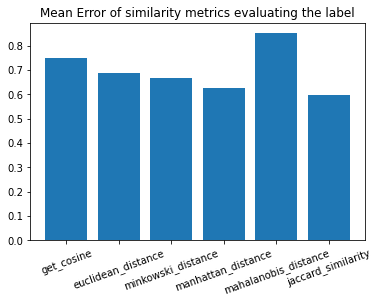

In [29]:
results = pd.DataFrame(columns=['metric', 'mean_error'])

for metric in similarity_functions:
    df_test = df_clean.copy()
    df_test = processing_pipeline(df_test, metric)
    results = results.append({'metric': metric.__name__, 'mean_error': mean_error(df_test)}, ignore_index=True)

plot_results(results)